In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import wordpunct_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, clone_model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.optimizers import Adam
from transformers import pipeline, DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA

2023-05-08 17:01:41.691043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id="contents"></a>

# Table of Contents

- [Problem Statement](#part1)
- [Data Description](#part2)
- [Exploratory Data Analysis](#part3)
- [Text Processing](#part4)
- [Naive Feed Forward Network](#part5)
- [Downsampling](#part6)
- [LSTM](#part7)
- [BERT](#part8)
- [ELMo](#part9)
- [Sentiment Analysis](#part10)
- [Latent Space Visualization](#part11)
- [Conclusion](#part12)

<a id="part1"></a>

# Problem Statement

[Return to contents](#contents)

Our main research question is: **Can we use the text of user reviews to predict the star ratings for reviews of businesses in Philadelphia?**

To answer this question, we'll try to build a model that takes a Yelp review and predicts the star rating. Then, to see whether star ratings accurately match sentiment analysis, we will compare both the true star rating labels and our predicted star ratings to the sentiment analysis results of a pretrained model from Hugging Face.

<a id="part2"></a>

# Data Description 

[Return to contents](#contents)

The data comes from the Yelp API and was downloaded directly from https://www.yelp.com/dataset. However, this data does not encompass every business/review which exists on Yelp; instead, only “Yelp recommended” reviews are included (i.e., those reviews which Yelp has algorithmically determined to be clear, high-quality, etc.). According to the Yelp FAQs, the dataset is limited to metropolitan areas centered around Montreal, Calgary, Toronto, Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison, and Cleveland. However, in our analysis, we found that the five cities which contained the most observations were Philadelphia, Nashville, Indianapolis, Tampa, and Tucson, which are not included in the metropolitan areas listed. Due to memory and performance constraints, we chose to narrow our focus to just restaurants in Philadelphia and their respective reviews.

The Yelp data contains four different datasets: business, review, tips, and users. Considering our project goals, we decided to train our models using the reviews dataset, which has the integer features stars (a rating of the business from 1 to 5), useful, funny, and cool (the last three of which represent positive reactions to the reviews). Additionally, the reviews dataset contains text reviews in string form, the date of the reviews, and IDs connected to the reviews (unique), businesses, and users. After filtering the data to only reviews pertaining to restaurants in Philadelphia, this dataset contains 687,289 rows and 9 columns.


<a id="part3"></a>

# Exploratory Data Analysis

[Return to contents](#contents)

## Loading Data

The initial dataset was quite large (even when we limited our focus to only Philadelphia). Thus, we had to split the `.csv` files up, which is why we have this slightly clunky import code.

In [2]:
# load in review data from separate csv's located in data folder
# WARNING to add '/data' in the read_csv when running outside of DeepNote
review = []
for i in range(1, 8):
    review.append(pd.read_csv(f'data/review{i}.csv'))
review = pd.concat(review, ignore_index=True)

### Inspecting `review`

In [3]:
# Check for missing values
review.isnull().sum()/len(review.index)

review_id      0.0
user_id        0.0
business_id    0.0
stars          0.0
useful         0.0
funny          0.0
cool           0.0
text           0.0
date           0.0
dtype: float64

In [4]:
review.describe()

,stars,useful,funny,cool
count,687289.000000,687289.000000,687289.000000,687289.000000
mean,3.811699,1.101761,0.370848,0.550538
std,1.306959,2.531508,1.430542,1.850401
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,1.000000
max,5.000000,224.000000,227.000000,163.000000


Based on the code output shown above, there are no missing values in the review dataset. We plan to focus our analysis on the star ratings and the review text, so we created some visualizations to get a better sense of these columns. The histogram below shows that the plurality of reviews are five stars and there are more one-star reviews than two-star reviews. Therefore, there is a class imbalance in the data, which we will address later with downsampling.

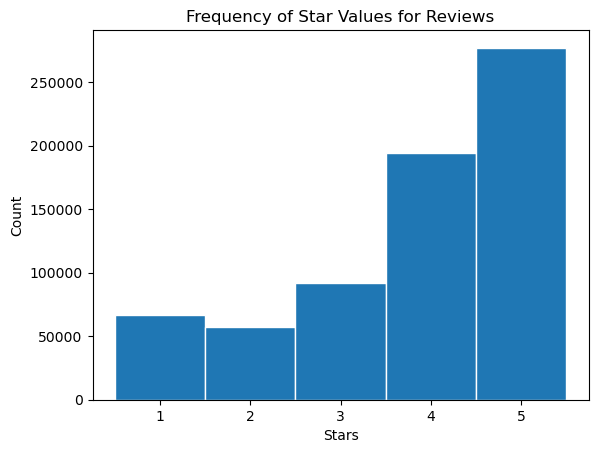

In [5]:
# Histogram of stars distribution
plt.hist(review['stars'], bins=np.arange(0.5, 6.5, 1), edgecolor="white")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.title("Frequency of Star Values for Reviews")
plt.show()

The following visualizations investigate the length of the reviews. Most reviews are short and the number of reviews of a given length generally decreases as the length increases, but there are more 4500-5000 character reviews than there are 4000-4500 character reviews. The boxplots indicate that reviews for businesses with two or three stars are slightly longer while reviews for businesses with five stars tend to be shorter, but generally reviews of all star ratings follow a very similar distribution. Additionally, for all star ratings, there are many outliers with long review lengths. Because most of the reviews are shorter, when pre-processing the reviews text we should be able to truncate longer reviews without too much negative impact on model performance.

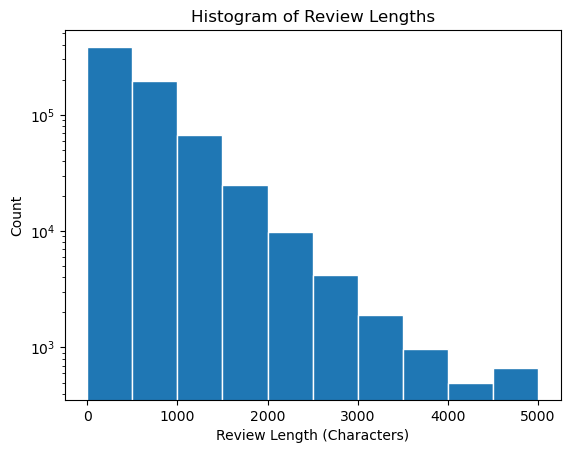

In [6]:
# Distribution of review lengths
plt.hist(review['text'].str.len(), edgecolor="white")
plt.xlabel('Review Length (Characters)')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Histogram of Review Lengths')
plt.show()

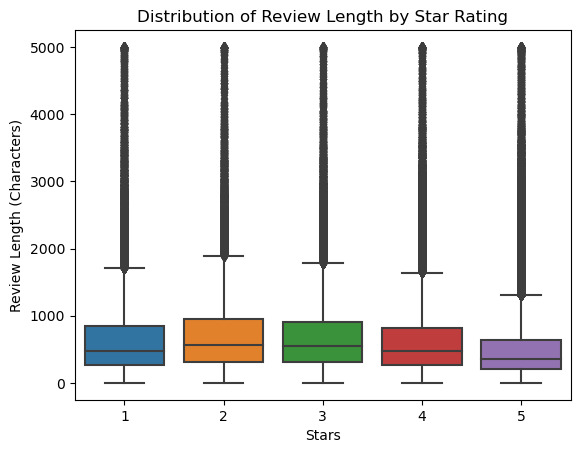

In [7]:
# Review length vs. star rating
sns.boxplot(x=review['stars'], y=review['text'].str.len())
plt.xlabel("Stars")
plt.ylabel("Review Length (Characters)")
plt.title("Distribution of Review Length by Star Rating");

<a id="part4"></a>

# Text Processing

[Return to contents](#contents)

In order to prepare reviews, we simply use text as our input variable and stars as our output variable. We then save the arrays for future use. However, in order to feed text into a neural network, we first had to tokenize it -- this process took a long time, so the code is commented out (so that it is not accidentally run). We utilized `wordpunct_tokenize()` in order to pre-process the text. Additionally, because we chose to pad the sequences, we started counting our word to index dictionary at 1.

In [8]:
# clean and tokenize the reviews
def clean(string):
    return wordpunct_tokenize(string.lower())
review['text_old'] = review['text']
review['text'] = review['text'].apply(clean)
words = review['text'].apply(set)
words = set().union(*words)
len(words)

166581

In [9]:
# Create word to index and index to word dictionaries
word2idx = {w: i + 1 for i, w in enumerate(words)}
f = open("data/word2idx.pkl", "wb")
pickle.dump(word2idx, f)
f.close()

idx2word = {v: k for k,v in word2idx.items()}
word2idx['<PAD>'] = 0
idx2word[0] = '<PAD>'

In [10]:
# Encode the words
X = review['text'].apply(lambda r: [word2idx[w] for w in r])
X

0         [38066, 130526, 60096, 62666, 162421, 62666, 1...
1         [96096, 18031, 92468, 129763, 47722, 76110, 44...
2         [144743, 105417, 32626, 33754, 68683, 29591, 3...
3         [104138, 120614, 60216, 13404, 133213, 147437,...
4         [130876, 68, 90495, 89746, 146319, 68683, 6474...
                                ...                        
687284    [92877, 62666, 96096, 31551, 81228, 99621, 626...
687285    [96096, 103513, 99853, 160943, 81228, 68683, 3...
687286    [96096, 137268, 155363, 90332, 124259, 2457, 6...
687287    [77088, 143998, 27781, 77088, 96096, 103513, 9...
687288    [94098, 108758, 92468, 144743, 82462, 43180, 1...
Name: text, Length: 687289, dtype: object

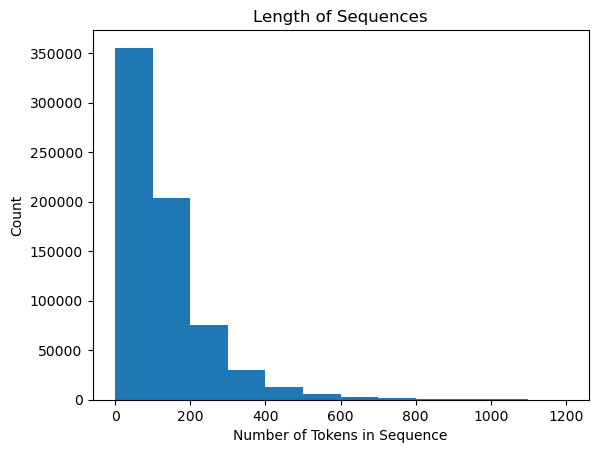

In [11]:
# Histogram of sequence length
plt.hist(X.apply(len), bins=np.arange(0, 1300, 100))
plt.xlabel("Number of Tokens in Sequence")
plt.ylabel("Count")
plt.title("Length of Sequences");

Based on the histogram above, we decided to truncate our reviews to length 256 since most reviews are less than 200 tokens. This would help with saving memory space and reducing training time while preserving most of the data.

In [12]:
# Padding and truncation
max_words = 256
X = pad_sequences(X, max_words)
X.shape

(687289, 256)

In [13]:
# Saving the processed data
y = review['stars'].to_numpy()
np.savez_compressed('data/reviews.npz', X=X, y=y)

# Baseline Models

First, we load in the data from `reviews.npz` and convert the data to `tensorflow Dataset`.

In [14]:
# for quick loading
reviews = np.load('data/reviews.npz')
X, y = reviews['X'], reviews['y'] - 1
with open('data/word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)

## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=109)

## check shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((439864, 256), (439864,), (109967, 256), (109967,), (137458, 256), (137458,))

In [15]:
## Create data pipeline
batch_size = 1024
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(len(X_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2023-05-08 17:03:41.175139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id="part5"></a>

## Naive Feed Forward Network

[Return to contents](#contents)

This is the most naive approach to the problem. Given the complexity of the text, we didn't expect a feed forward neural network to perform very well, specifically because it would have issues remembering context (given that it has no recurrent relationships between different nodes).

In [16]:
ff1 = Sequential(name='Naive_FFNN')
ff1.add(Dense(64, activation='relu',input_dim=X_train.shape[1]))
ff1.add(Dense(5, activation='softmax'))
ff1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ff1.summary()

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Fit model
ff1.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
430/430 [==============================] - 5s 5ms/step - loss: 4785.9727 - accuracy: 0.3392 - val_loss: 44.3978 - val_accuracy: 0.3894
Epoch 2/10
430/430 [==============================] - 2s 4ms/step - loss: 19.8816 - accuracy: 0.3982 - val_loss: 11.6953 - val_accuracy: 0.3976
Epoch 3/10
430/430 [==============================] - 2s 4ms/step - loss: 7.2257 - accuracy: 0.4016 - val_loss: 6.6105 - val_accuracy: 0.3989
Epoch 4/10
430/430 [==============================] - 3s 4ms/step - loss: 4.2924 - accuracy: 0.4024 - val_loss: 4.6103 - val_accuracy: 0.3995
Epoch 5/10
430/430 [==============================] - 2s 4ms/step - loss: 3.1323 - accuracy: 0.4027 - val_loss: 3.6197 - val_accuracy: 0.3997
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 2.5120 - accuracy: 0.4028 - val_loss: 3.0011 - val_accuracy: 0.3999
Epoch 7/10
430/430 [==============================] - 2s 4ms/step - loss: 2.1351 - accuracy: 0.4030 - val_loss: 2.6213 - val_accuracy: 0.3999


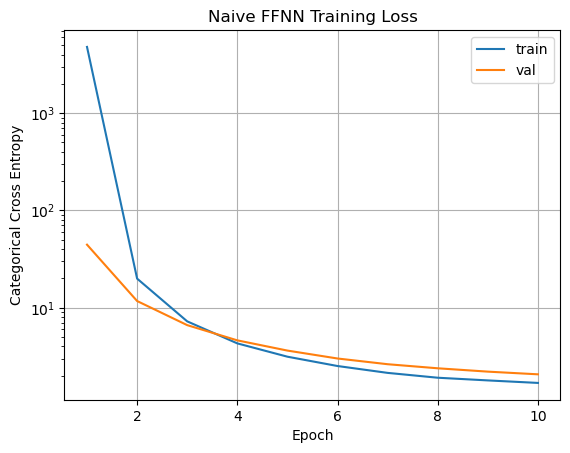

In [18]:
# Training history
plt.plot(range(1, 11), ff1.history.history['loss'], label='train')
plt.plot(range(1, 11), ff1.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.title('Naive FFNN Training Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

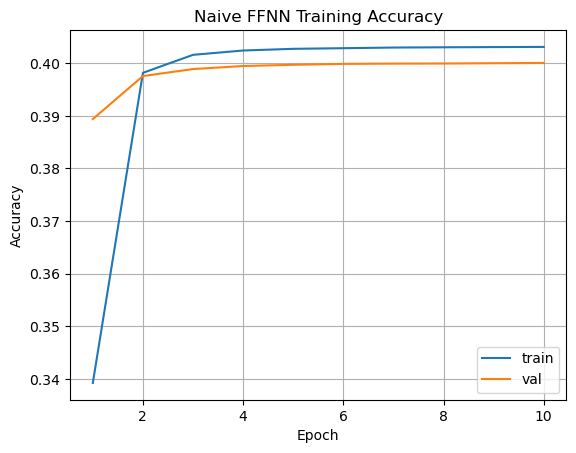

In [19]:
# Training history
plt.plot(range(1, 11), ff1.history.history['accuracy'], label='train')
plt.plot(range(1, 11), ff1.history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Naive FFNN Training Accuracy')
plt.legend()
plt.grid()
plt.show()

In [20]:
# Evaluate on test data
ff1.evaluate(test_data)

135/135 [==============================] - 1s 2ms/step - loss: 2.0101 - accuracy: 0.4057


[2.010068416595459, 0.4057021141052246]

135/135 [==============================] - 0s 1ms/step


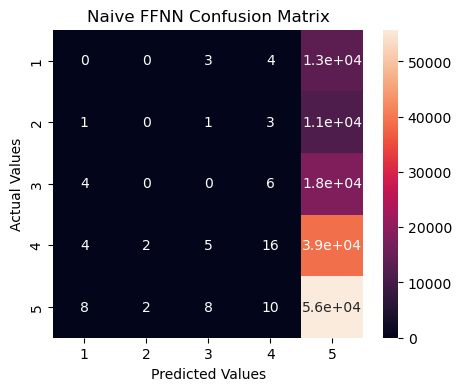

In [21]:
y_pred = np.argmax(ff1.predict(X_test, batch_size = 1024), axis = -1).flatten() 

# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('Naive FFNN Confusion Matrix')
plt.ylabel('Actual Values') 
plt.xlabel('Predicted Values') 
plt.show()

As expected, this model did not perform very well. While we only trained for 10 epochs, we could see that the model accuracy on the validation set would not get much higher than 40%. We also observed that it predicted 5 stars for almost every review because there was an over-concentration of 5-star reviews in the dataset from Yelp. This shows that the class imbalance we identified in EDA has a large negative impact on model performance. Therefore, we used downsampling to fix this for future models.

<a id="part6"></a>

## Downsampling

[Return to contents](#contents)

We resampled reviews for the training and validation data, restricting our downsampled data to contain 37,000 reviews from each star-class for training and around 9,000 for the validation data. This is because 2-star reviews were the least frequent class of reviews in our histograms and there were about 50,000 of them before doing the train-test split. We did not perform downsampling on the test data so that we can evaluate the model on data that accurately reflects real world data.

In [22]:
# Downsampling
X_d_train, y_d_train, X_d_val, y_d_val = [], [], [], []

_, train_counts = np.unique(y_train, return_counts = True)
smallest_train = min(train_counts)
_, val_counts = np.unique(y_val, return_counts = True)
smallest_val = min(val_counts)

for i in range(5):
    X_di_train, y_di_train = resample(X_train[y_train == i], y_train[y_train == i], 
                                      random_state = 109, 
                                      n_samples = smallest_train, 
                                      replace = False)
    X_di_val, y_di_val = resample(X_val[y_val == i], y_val[y_val == i], 
                                  random_state = 109,
                                  n_samples = smallest_val,
                                  replace = False)
    X_d_train.append(X_di_train)
    y_d_train.append(y_di_train)
    
    X_d_val.append(X_di_val)
    y_d_val.append(y_di_val)
    
X_d_train = np.stack(X_d_train).reshape(smallest_train * 5, X.shape[1])
y_d_train = np.stack(y_d_train).flatten()

X_d_val = np.stack(X_d_val).reshape(smallest_val * 5, X.shape[1])
y_d_val = np.stack(y_d_val).flatten()

X_d_train.shape, y_d_train.shape, X_d_val.shape, y_d_val.shape

((183970, 256), (183970,), (46725, 256), (46725,))

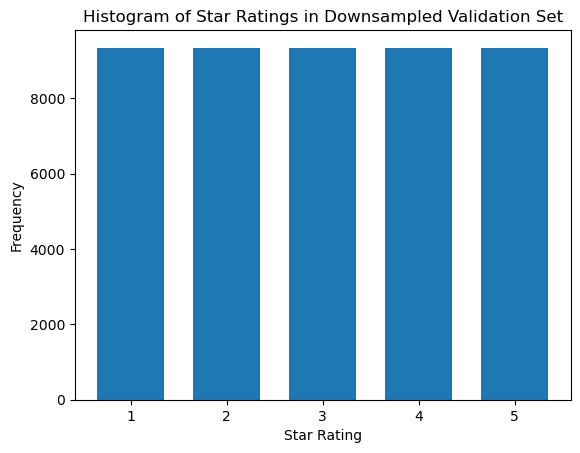

In [23]:
# Ensuring the downsampling worked
plt.hist(y_d_val, bins=np.linspace(-0.5, 4.5, 6), rwidth=0.7)
plt.xticks(range(5), range(1, 6))
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Star Ratings in Downsampled Validation Set')
plt.show()

In [24]:
# Convert to tensorflor datasets
d_train_data = tf.data.Dataset.from_tensor_slices((X_d_train, y_d_train)).shuffle(len(X_d_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
d_val_data = tf.data.Dataset.from_tensor_slices((X_d_val, y_d_val)).shuffle(len(X_d_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

To see if downsampling improves model performance, we refit the feed foward model on the downsampled data. 

In [25]:
ff2 = clone_model(ff1)
ff2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ff2.summary()

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [26]:
ff2.fit(d_train_data, validation_data=d_val_data, epochs=10)

Epoch 1/10
180/180 [==============================] - 2s 5ms/step - loss: 9569.0947 - accuracy: 0.2112 - val_loss: 177.7814 - val_accuracy: 0.2074
Epoch 2/10
180/180 [==============================] - 1s 4ms/step - loss: 83.8810 - accuracy: 0.2049 - val_loss: 36.7960 - val_accuracy: 0.2022
Epoch 3/10
180/180 [==============================] - 1s 4ms/step - loss: 24.8715 - accuracy: 0.2016 - val_loss: 17.7947 - val_accuracy: 0.2011
Epoch 4/10
180/180 [==============================] - 1s 4ms/step - loss: 12.8554 - accuracy: 0.1998 - val_loss: 11.5015 - val_accuracy: 0.2011
Epoch 5/10
180/180 [==============================] - 1s 4ms/step - loss: 8.1190 - accuracy: 0.2003 - val_loss: 8.5820 - val_accuracy: 0.2008
Epoch 6/10
180/180 [==============================] - 1s 4ms/step - loss: 5.6655 - accuracy: 0.1999 - val_loss: 6.9667 - val_accuracy: 0.2006
Epoch 7/10
180/180 [==============================] - 1s 4ms/step - loss: 4.3684 - accuracy: 0.1985 - val_loss: 5.8484 - val_accuracy: 0.

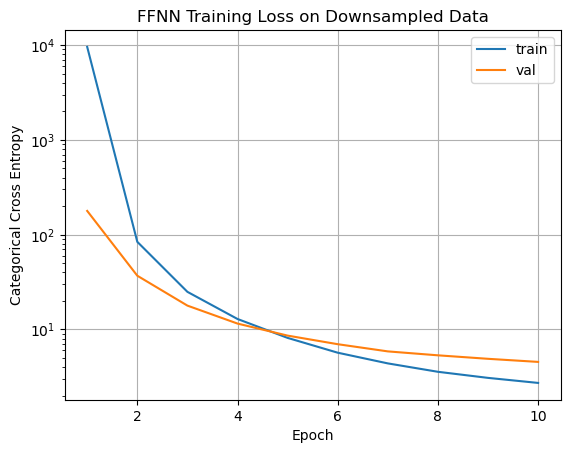

In [27]:
plt.plot(range(1, 11), ff2.history.history['loss'], label='train')
plt.plot(range(1, 11), ff2.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.title('FFNN Training Loss on Downsampled Data')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

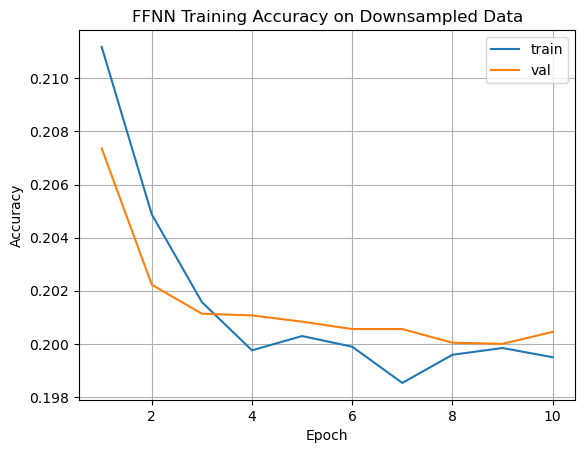

In [28]:
plt.plot(range(1, 11), ff2.history.history['accuracy'], label='train')
plt.plot(range(1, 11), ff2.history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FFNN Training Accuracy on Downsampled Data')
plt.legend()
plt.grid()
plt.show()

In [29]:
ff2.evaluate(test_data)

135/135 [==============================] - 1s 2ms/step - loss: 3.8520 - accuracy: 0.0832


[3.851984739303589, 0.08315267413854599]

135/135 [==============================] - 0s 2ms/step


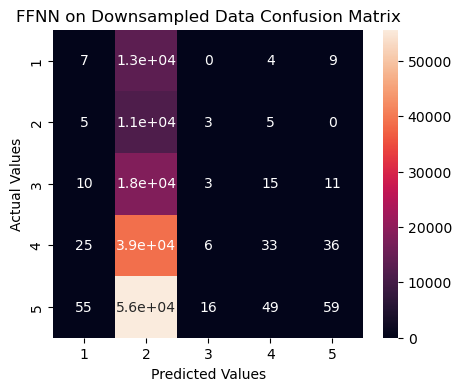

In [30]:
y_pred = np.argmax(ff2.predict(X_test, batch_size = 1024), axis = -1).flatten() 

# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('FFNN on Downsampled Data Confusion Matrix')
plt.ylabel('Actual Values') 
plt.xlabel('Predicted Values') 
plt.show()

Even with downsampled data, the feed forward network still fails to perform better than a random guess. We were not quite sure why this confusion matrix emerged after downsampling, but it seems that it might just indicate tha tthe model is, essentially, guessing, rather than being able to pick up on any underlying patterns in the data. This motivates a shift to more complex models that are more suited to language tasks.

<a id="part7"></a>

# LSTM with `keras` Embedding Layer

[Return to contents](#contents)

Given that our naive model performed poorly, even after downsampling, we decided that a language model was necessary in order to get a higher level of test accuracy we desired. The first language-based model architecture we tried was an LSTM model with embeddings trained from scratch. We chose this model because it was simple (compared to some of the later encoder/decoder architectures which we tested). Additionally, as compared to GRU, it seemed that because LSTM is slightly more complex, and we have a larger dataset, it might make sense to use the more complex LSTM, which is better at language tasks with long sequences. However, we found that our model suffered from overfitting (after around 5 epochs, the validation loss began to rise quickly). 


In [31]:
# Build LSTM model
EMB_DIM = 32
inputs = Input(shape=(X_d_train.shape[1],))
n = Embedding(len(word2idx) + 1, EMB_DIM, mask_zero=True)(inputs)
n = LSTM(EMB_DIM)(n)
outputs = Dense(5, activation='softmax')(n)
lstm = Model(inputs=inputs, outputs=outputs, name="LSTM")
lstm.summary()
lstm.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 32)           5330624   
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,339,109
Trainable params: 5,339,109
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Fit LSTM model
num_epochs=5
lstm.fit(d_train_data, validation_data=d_val_data, epochs=num_epochs)

Epoch 1/5
180/180 [==============================] - 153s 831ms/step - loss: 1.2482 - accuracy: 0.4314 - val_loss: 0.9973 - val_accuracy: 0.5562
Epoch 2/5
180/180 [==============================] - 144s 799ms/step - loss: 0.9217 - accuracy: 0.5949 - val_loss: 0.9148 - val_accuracy: 0.5984
Epoch 3/5
180/180 [==============================] - 157s 874ms/step - loss: 0.8500 - accuracy: 0.6325 - val_loss: 0.9287 - val_accuracy: 0.5947
Epoch 4/5
180/180 [==============================] - 145s 801ms/step - loss: 0.8027 - accuracy: 0.6589 - val_loss: 0.9174 - val_accuracy: 0.6010
Epoch 5/5
180/180 [==============================] - 149s 826ms/step - loss: 0.7624 - accuracy: 0.6808 - val_loss: 0.9423 - val_accuracy: 0.5987


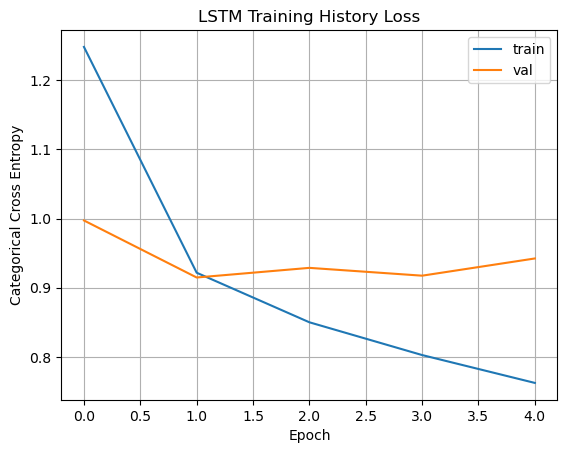

In [33]:
# Training history
plt.plot(np.arange(num_epochs), lstm.history.history['loss'], label='train')
plt.plot(np.arange(num_epochs), lstm.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.title('LSTM Training History Loss')
plt.legend()
plt.grid()
plt.show()

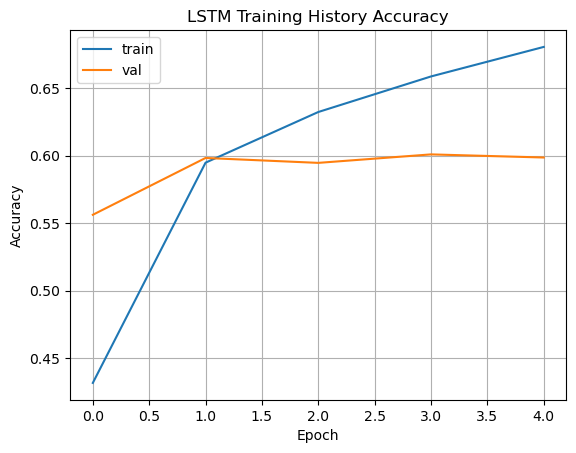

In [34]:
plt.plot(np.arange(num_epochs), lstm.history.history['accuracy'], label='train')
plt.plot(np.arange(num_epochs), lstm.history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Training History Accuracy')
plt.legend()
plt.grid()
plt.show()

## Evaluation

Although the LSTM model achieves a training accuracy of almost 70%, the validation and test accuracy were only around 60%, and the validation accuracy did not improve after the second epoch. It seems as though the model overfit to the data. However, the confusion matrix looks good. It seems that when the LSTM model predicts the wrong class, it is usually only one star off.

In order to try improving the accuracy of this LSTM model, we tried fine-tuning its hyperparameters by adding a larger embedding dimension and by adding additional LSTM layers. While these changes improved the training accuracy, they led to even more overfitting. To try to improve the overfitting, we also tried adding L2 and L1L2 kernel regularization. However, this did not improve the overfitting but hurt the training accuracy. As a result, we chose to take a different approach and try ELMo embeddings and transfer learning with BERT.

In [35]:
lstm.evaluate(test_data)

135/135 [==============================] - 32s 236ms/step - loss: 0.9094 - accuracy: 0.6128


[0.9093692898750305, 0.6128344535827637]

135/135 [==============================] - 31s 222ms/step


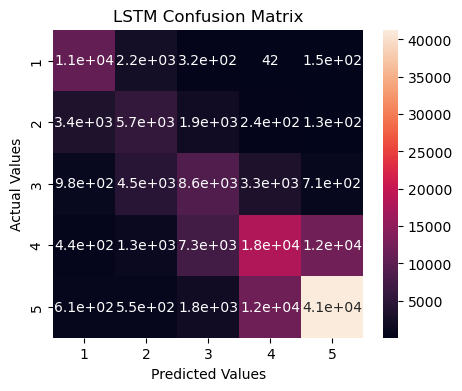

In [36]:
y_pred = np.argmax(lstm.predict(X_test, batch_size = 1024), axis = -1).flatten() 

# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('LSTM Confusion Matrix')
plt.ylabel('Actual Values') 
plt.xlabel('Predicted Values') 
plt.show()

<a id="part8"></a>

# BERT

[Return to contents](#contents)

We decided to try BERT for a few reasons. For one, transfer learning generally appealed to us, given that we had decreased the amount of data quite dramatically through downsampling. A model which utilizes transfer learning might allow us to still draw from a rich set of embeddings, even without having all the data to train those embeddings from scratch by ourselves.
Generally speaking, we hoped that the BERT architecture, which utilizes attention, might give us a higher accuracy by better taking context into account. (Indeed, based on reading some of the reviews, context is quite important. For example, many of the reviews use sarcasm or quotes/dialogue, which would be quite confusing without having embeddings that fully capture semantic and contextual meaning).

In [37]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [38]:
'''
def decode(arr):
    return [idx2word[i] for i in list(filter(lambda x: x != 0, arr))]
'''

'\ndef decode(arr):\n    return [idx2word[i] for i in list(filter(lambda x: x != 0, arr))]\n'

In [39]:
'''
# Tokenize data, truncating and padding to 256 for training speed purposes
X_bert_train = tokenizer([decode(arr) for arr in X_d_train],
                         is_split_into_words=True,
                         return_tensors='tf',
                         max_length=256,
                         padding='max_length',
                         truncation=True)
X_bert_val = tokenizer([decode(arr) for arr in X_d_val],
                         is_split_into_words=True,
                         return_tensors='tf',
                         max_length=256,
                         padding='max_length',
                         truncation=True)
X_bert_test = tokenizer([decode(arr) for arr in X_test],
                         is_split_into_words=True,
                         return_tensors='tf',
                         max_length=256,
                         padding='max_length',
                         truncation=True)
'''

"\n# Tokenize data, truncating and padding to 256 for training speed purposes\nX_bert_train = tokenizer([decode(arr) for arr in X_d_train],\n                         is_split_into_words=True,\n                         return_tensors='tf',\n                         max_length=256,\n                         padding='max_length',\n                         truncation=True)\nX_bert_val = tokenizer([decode(arr) for arr in X_d_val],\n                         is_split_into_words=True,\n                         return_tensors='tf',\n                         max_length=256,\n                         padding='max_length',\n                         truncation=True)\nX_bert_test = tokenizer([decode(arr) for arr in X_test],\n                         is_split_into_words=True,\n                         return_tensors='tf',\n                         max_length=256,\n                         padding='max_length',\n                         truncation=True)\n"

In [40]:
'''
# Create data pipeline
bert_train = tf.data.Dataset.from_tensor_slices((
    (X_bert_train['input_ids'], X_bert_train['attention_mask']), y_d_train))
bert_val = tf.data.Dataset.from_tensor_slices((
    (X_bert_val['input_ids'], X_bert_val['attention_mask']), y_d_val))
bert_test = tf.data.Dataset.from_tensor_slices((
    (X_bert_test['input_ids'], X_bert_test['attention_mask']), y_test))
'''

"\n# Create data pipeline\nbert_train = tf.data.Dataset.from_tensor_slices((\n    (X_bert_train['input_ids'], X_bert_train['attention_mask']), y_d_train))\nbert_val = tf.data.Dataset.from_tensor_slices((\n    (X_bert_val['input_ids'], X_bert_val['attention_mask']), y_d_val))\nbert_test = tf.data.Dataset.from_tensor_slices((\n    (X_bert_test['input_ids'], X_bert_test['attention_mask']), y_test))\n"

In [41]:
'''
bert_train.save('data/bert_train_256')
bert_val.save('data/bert_val_256')
bert_test.save('data/bert_test_256')
'''

"\nbert_train.save('data/bert_train_256')\nbert_val.save('data/bert_val_256')\nbert_test.save('data/bert_test_256')\n"

We had to take a smaller subset of the data in order to train BERT; even though we were not tuning the BERT weights themselves, the large amount of data was making training and evaluation very slow.

In [42]:
# Take a small subset of the data for training speed purposes
batch_size = 512
bert_train = tf.data.Dataset.load('data/bert_train_256').shuffle(200000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).take(32)
bert_val = tf.data.Dataset.load('data/bert_val_256').shuffle(50000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).take(6)
bert_test = tf.data.Dataset.load('data/bert_test_256').shuffle(50000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).take(24)

In [43]:
tf.keras.backend.clear_session()
bert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5, name='bert', from_pt=True)
bert.layers[0].trainable = False # Freeze base layer weights for transfer learning
bert.summary()
bert.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=['accuracy'])
'''
bert.fit(bert_train,
         validation_data=bert_val,
         epochs=10,
         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=2,
                                                     restore_best_weights=True)])
'''

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Model: "bert"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,957,317
Trainable params: 594,437
Non-trainable params: 66,362,880
_________________________________________________________________


"\nbert.fit(bert_train,\n         validation_data=bert_val,\n         epochs=10,\n         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',\n                                                     patience=2,\n                                                     restore_best_weights=True)])\n"

In [44]:
# bert.save_weights('data/bert')
# np.save('data/bert_history.npy', bert.history)

In [46]:
bert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5, name='bert', from_pt=True)
bert.load_weights('data/bert') # Reload weights (need to compile and )
bert.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(), metrics=['accuracy'])
#bert_history = np.load('data/bert_history.npy', allow_pickle = True).item()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

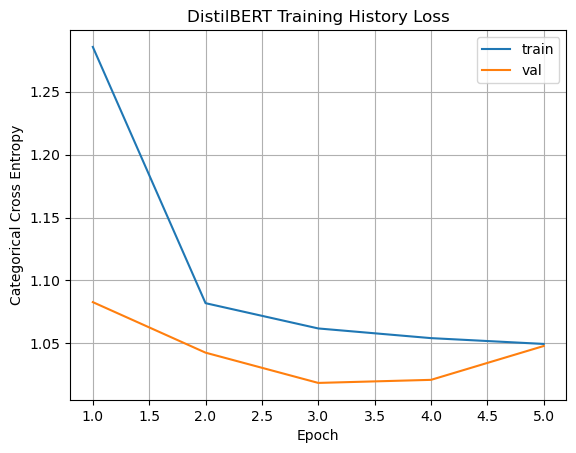

In [ ]:
plt.plot(range(1, len(bert_history.history['loss']) + 1), bert_history.history['loss'], label='train')
plt.plot(range(1, len(bert_history.history['val_loss']) + 1), bert_history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.title('DistilBERT Training History Loss')
plt.legend()
plt.grid()
plt.show()

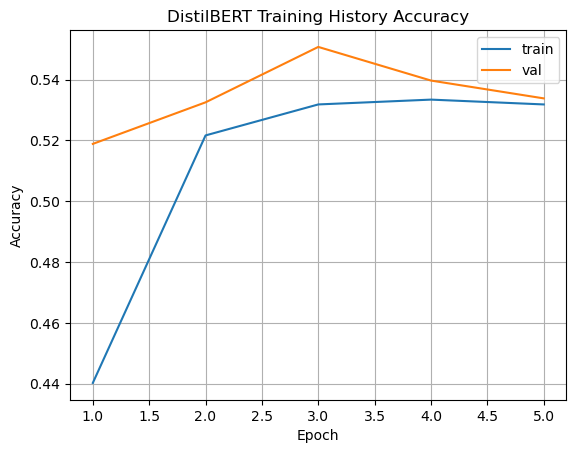

In [ ]:
plt.plot(range(1, len(bert_history.history['accuracy']) + 1), bert_history.history['accuracy'], label='train')
plt.plot(range(1, len(bert_history.history['val_accuracy']) + 1), bert_history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('DistilBERT Training History Accuracy')
plt.legend()
plt.grid()
plt.show()

## Evaluation

In [47]:
bert.evaluate(bert_test)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
24/24 [==============================] - 1565s 64s/step - loss: 0.9552 - accuracy: 0.5740


[0.9552136063575745, 0.573974609375]

24/24 [==============================] - 1666s 69s/step


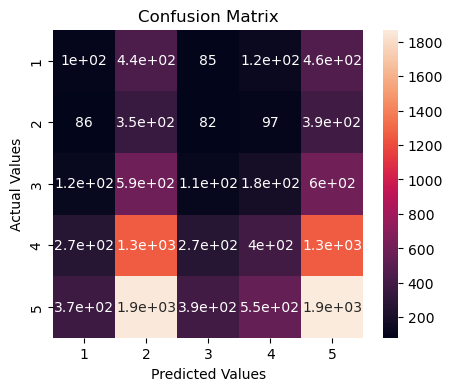

In [48]:
X_bert_test = bert_test.map(lambda x, y: x)
y_bert_test = bert_test.map(lambda x, y: y).unbatch()
y_bert_test = [*y_bert_test.as_numpy_iterator()]
y_pred = np.argmax(bert.predict(X_bert_test).logits, axis=-1)
# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_bert_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('DistilBERT Confusion Matrix')
plt.ylabel('Actual Values') 
plt.xlabel('Predicted Values') 
plt.show()

We are not quite sure what to make of this confusion matrix. While it certainly makes sense that BERT would predict that things are five-star reviews when they are actually lower, given that we also observed, anecdotally, that the reviews themselves are sometimes much more positive than the ratings, we were not sure why BERT would predict so many two-star reviews. It is also odd that the model has the same issues with mispredicting 2-star reviews as five-star reviews. 

<a id="part9"></a>

# ELMo

[Return to contents](#contents)

With the help of the TensorFlow API, a blog post from Sebastian Correa, and pre-trained ELMo embeddings from TensorFlow Hub, we were able to create a custom ELMO layer which we used instead of the generic keras Embedding layer that we had used in our initial models. Unfortunately, we found that these ELMo embeddings are not compatible with the rest of the notebook, given that they rely upon using tensorflow v1. As a result, we have decided that it is best to just include the commented-out code. We still have some of the output from a previous run of the notebook, but, as mentioned above, that output is not a direct result of the final run of the notebook. Additionally, all of the output included *could* be generated by the code provided here. 

Overall, as discussed later on, this method was not quite as successful as either BERT or the simple LSTM. We added an ELMo embedding layer to both a basic feed-forward neural network and an LSTM; the ELMo embeddings with the FFNN performed better than the LSTM with ELMo embeddings. This might be because the LSTM simply had too many parameters to be trained in the short amount of epochs that we were able to run. 

In this first cell, we downsample the raw data, because the elmo module from TensorFlow Hub expects to take in untokenized data. 

In [ ]:
X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(review['text_old'], review['stars'] - 1, test_size=0.2, random_state=109)
X_e_train, X_e_val, y_e_train, y_e_val = train_test_split(review['text_old'], review['stars'] - 1, test_size=0.2, random_state=109)

# Downsampling
X_ed_train, y_ed_train, X_ed_val, y_ed_val = [], [], [], []

for i in range(5):
    X_edi_train, y_edi_train = resample(X_e_train[y_e_train == i], y_e_train[y_e_train == i], 
                                      random_state = 109, 
                                      n_samples = smallest_train, 
                                      replace = False)
    X_edi_val, y_edi_val = resample(X_e_val[y_e_val == i], y_e_val[y_e_val == i], 
                                  random_state = 109,
                                  n_samples = smallest_val,
                                  replace = False)
    X_ed_train.append(X_edi_train)
    y_ed_train.append(y_edi_train)
    
    X_ed_val.append(X_edi_val)
    y_ed_val.append(y_edi_val)
    
X_ed_train = np.stack(X_ed_train).reshape(smallest_train * 5, -1)
y_ed_train = np.stack(y_ed_train).flatten()

X_ed_val = np.stack(X_ed_val).reshape(smallest_val * 5, -1)
y_ed_val = np.stack(y_ed_val).flatten()

In [ ]:
# using older version of tensorflow in order to be compatible with Elmo
# NOTE: this code comes from the blog of Sebastian Correa
# attr: https://scorrea92.medium.com/elmo-tensorflow-implementation-f372dfc7da4e
"""
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub    
tf.disable_v2_behavior()

class Elmo(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        # default length of embedding 
        self.dimensions = 1024
        self.trainable = True
        super(Elmo, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))
        super(Elmo, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(
            tf.keras.backend.squeeze(tf.keras.backend.cast(x, tf.string), axis=1),
            as_dict=True,
            #signature = default means that we are passing in strings, not tokens
            signature='default',
            )['default']
        return result

    # boilerplat compute mask
    def compute_mask(self, inputs, mask=None):
        return tf.keras.backend.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)
    
    def get_config(self):
        config = super(Elmo, self).get_config()
        #config.update({"units": self.units})
        return config

class ElmoForLSTM(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.max_length = 500
        self.dimensions = (500, 1024)
        self.trainable = False
        super(ElmoForLSTM, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))
        super(ElmoForLSTM, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(
            tf.keras.backend.squeeze(tf.keras.backend.cast(x, tf.string), axis=1),
            as_dict=True,
            signature='default',
            # note that this is the key difference -- using "elmo" key instead of "default"
            )['elmo']
        return result

    def compute_mask(self, inputs, mask=None):
        return tf.keras.backend.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)
    
    def get_config(self):
        config = super(ElmoForLSTM, self).get_config()
        #config.update({"units": self.units})
        return config
"""

Unfortunately, we had to cut our batch size down to 16, which slowed down training a lot. Initially, we were able to train the entire dataset, with a batch size of 256, in around 1 hour. However, in subsequent tests, we found that we were only able to run part of the dataset with a batch size of 16, due to memory errors we ran into on the GPU. This likely led to worse results from our model, although it is worth noting that the accuracies reported here are not much lower than the accuracies initially found when we trained on the entire dataset for the same number of epochs. 

The FFNN with ELMo embeddings achieved a test accuracy of 56.5%, while the LSTM with ELMo embeddings achieved a test accuracy of 43.4%. 

In [ ]:
# Launch the graph in a session.
# Because we are using tensorflow v1, it is necessary to use a "session" (eager execution is off, we are in graph mode)
"""
tf.keras.backend.clear_session()
sess = tf.compat.v1.Session()
tf.keras.backend.set_session(sess)

batch_size = 16
input_text = Input(shape=(1,), dtype="string", name='input_0')
x = Elmo(trainable=False)(input_text)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation="softmax")(x)

elmo_ffnn = Model(inputs=[input_text], outputs=x)

elmo_ffnn.summary()
"""

In [ ]:
# Actually fitting the model
## DO NOT RUN -- instead load, the model in
"""
history = elmo_ffnn.fit(train_dataset, validation_data = val_dataset, callbacks = [es, checkpoint], epochs=20)
np.save('data/ffnn_history.npy',history.history)
sess.close()
"""
"""
# # because we're using tf1.x, we need to run inside of a session
# sess = tf.compat.v1.Session()
# tf.keras.backend.set_session(sess)
# initialize weights -- otherwise, model will not be able to fit to data
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

elmo_ffnn.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam", 
              metrics=['accuracy'])

# in case we want to load weights rather than training the model 
elmo_ffnn.load_weights("data/ffnn.elmo.h5", by_name = True)
elmo_ffnn_history = np.load('data/elmo_ffnn_history.npy', allow_pickle='TRUE').item()
"""

In [142]:
# re-compiling model after weights
"""
elmo_ffnn.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam", 
              metrics=['accuracy'])

# take a subset of the data in order to speed things up
train_dataset = tf.data.Dataset.from_tensor_slices((X_ed_train, y_ed_train))\
                    .shuffle(len(X_ed_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)\
                    .take(2048)
test_dataset = tf.data.Dataset.from_tensor_slices((X_e_test, y_e_test))\
                    .shuffle(len(X_e_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)\
                    .take(348)
val_dataset = tf.data.Dataset.from_tensor_slices((X_ed_val, y_ed_val))\
                    .shuffle(len(X_ed_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)\
                    .take(1024)

es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2, restore_best_weights = True)
filepath = 'ffnn.epoch{epoch:02d}-loss{val_loss:.2f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor= "val_loss",
                             verbose=1, 
                             save_best_only=False,
                             save_weights_only = True)
"""

In [143]:
# Launch the graph in a session.
"""
# tf.keras.backend.clear_session()
# sess = tf.compat.v1.Session()
# tf.keras.backend.set_session(sess)

input_text = Input(shape=(1,), dtype="string", name='input_0')
x = ElmoForLSTM(trainable=False)(input_text)
x = tf.keras.layers.LSTM(32)(x)
x = tf.keras.layers.Dense(5, activation="softmax")(x)
elmo_lstm = Model(inputs=[input_text], outputs=x)

elmo_lstm.summary()
"""

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_0 (InputLayer)        [(None, 1)]               0         
                                                                 
 elmo_for_lstm (ElmoForLSTM)  (None, None, 1024)       0         
                                                                 
 lstm (LSTM)                 (None, 32)                135296    
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 135,461
Trainable params: 135,461
Non-trainable params: 0
_________________________________________________________________


In [144]:
# JUST AS BEFORE -- DO NOT RUN THIS!!! 
"""
history = elmo_lstm.fit(train_dataset, validation_data = val_dataset, callbacks = [es, checkpoint], epochs=20)
np.save('data/lstm_history.npy',history.history)
sess.close()
"""
# sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())
"""
elmo_lstm.load_weights("data/lstm.elmo.h5")
elmo_lstm_history = np.load('data/elmo_lstm_history.npy', allow_pickle='TRUE').item()

# 'binary_crossentropy'
elmo_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam", 
              metrics=['accuracy'])

# have to re-batch and prepare data pipeline because we're in a "new session"
# take a subset of the data in order to speed things up
train_dataset = tf.data.Dataset.from_tensor_slices((X_ed_train, y_ed_train)) \
     .shuffle(len(X_ed_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE) \
      .take(2048)
test_dataset = tf.data.Dataset.from_tensor_slices((X_e_test, y_e_test)) \
                     .shuffle(len(X_e_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE) \
                     .take(348)
val_dataset = tf.data.Dataset.from_tensor_slices((X_ed_val, y_ed_val)) \
                     .shuffle(len(X_ed_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE) \
                     .take(2048)

es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2, restore_best_weights = True)
filepath = 'data/lstm.epoch{epoch:02d}-loss{val_loss:.2f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor= "val_loss",
                             verbose=1, 
                             save_best_only=False,
                             save_weights_only = True)

# sess.close()
"""

2023-05-08 16:32:12.631827: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/kernel/Assign' id:8166 op device:{requested: '', assigned: ''} def:{{{node dense_2/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/kernel, dense_2/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


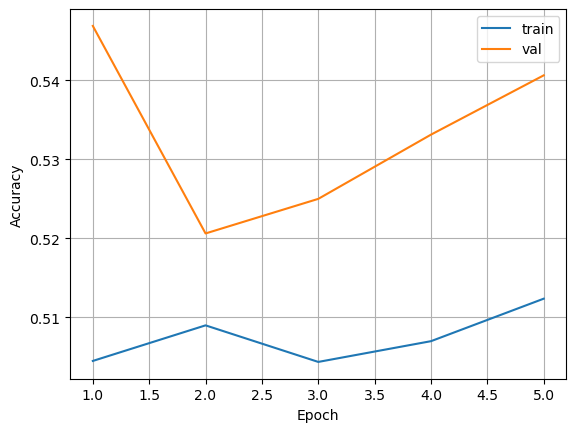

In [145]:
plt.plot(range(1, len(elmo_ffnn_history['acc']) + 1), elmo_ffnn_history['acc'], label='train')
plt.plot(range(1, len(elmo_ffnn_history['val_acc']) + 1), elmo_ffnn_history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("ELMo FFNN Accuracy")
plt.legend()
plt.grid()
plt.show()

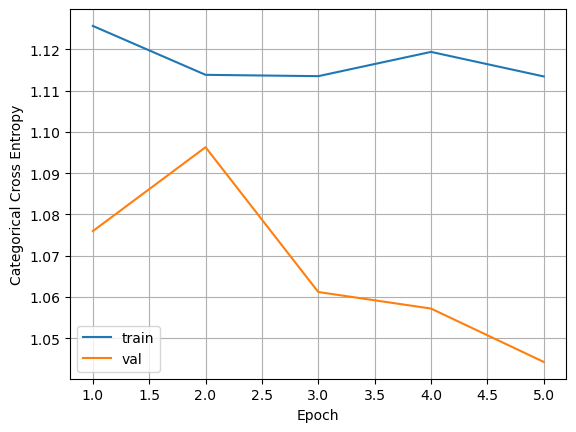

In [112]:
plt.plot(range(1, len(elmo_ffnn_history['loss']) + 1), elmo_ffnn_history['loss'], label='train')
plt.plot(range(1, len(elmo_ffnn_history['val_loss']) + 1), elmo_ffnn_history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.title("ELMo FFNN Loss")
plt.legend()
plt.grid()
plt.show()

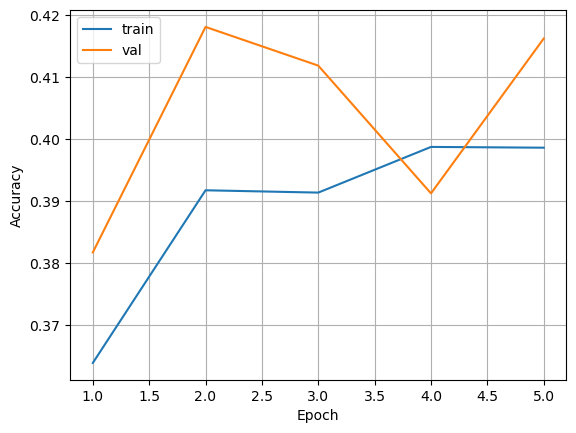

In [113]:
plt.plot(range(1, len(elmo_lstm_history['acc']) + 1), elmo_lstm_history['acc'], label='train')
plt.plot(range(1, len(elmo_lstm_history['val_acc']) + 1), elmo_lstm_history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("ELMo LSTM Accuracy")
plt.grid()
plt.show()

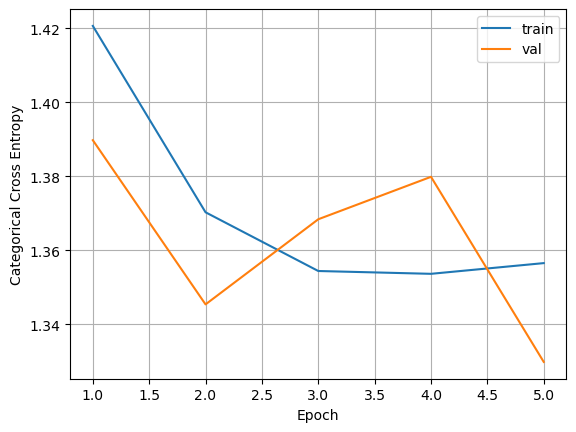

In [94]:
plt.plot(range(1, len(elmo_lstm_history['loss']) + 1), elmo_lstm_history['loss'], label='train')
plt.plot(range(1, len(elmo_lstm_history['val_loss']) + 1), elmo_lstm_history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.legend()
plt.grid()
plt.show()

The training history for both the FFNN with ELMo and the LSTM with ELMo were quite interesting -- it seemed as though the loss was a little bit "jumpy", which may have been an artifact of the learning rate (0.01). Additionally, possibly because of the smaller test and training size used, the validation dataset seemed to score higher accuracies than the training dataset. Again, while this could possibly be attributed to some randomness in how training and validation data were split up, it might also point to a weakness in selecting smaller dataset sizes to train. 

While these models were both more accurate than the FFNN without embeddings, they were still not able to perform as well as the simple LSTM. This may have been, again, because it took a long time to train (~2 hours for only 10% of the data), which forced us to cut training and cut the dataset size. Unfortunately, while trying to train the model, we did end up running into some issues with memory constraints on the GPU (and running the file locally was infeasible because of computing speed). Given more powerful computational services, we may have been able to achieve higher accuracies. However, given our time constraints, it seems that this was simply too complex a model for our assignment. 

## Evaluation

In [ ]:
"""
# sess = tf.compat.v1.Session()
# tf.keras.backend.set_session(sess)
# sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())
y_pred = np.argmax(elmo_ffnn.predict(X_e_test, verbose = 1), axis=-1)
# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_e_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('Confusion Matrix: ELMo FFNN')
plt.ylabel('Actual Values') 
plt.xlabel('Predicted Values') 
plt.show()

np.mean(y_pred == y_e_test.values) %
"""

In [ ]:
"""
y_pred = np.argmax(elmo_lstm.predict(X_e_test), axis=-1)
# Creating a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_e_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
# Plotting the confusion matrix
plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('Confusion Matrix: ELMo LSTM')
plt.ylabel('Actual Values') 
plt.xlabel('Predicted Values') 
plt.show()
np.mean(y_pred == y_e_test.values) % achieved 43.4% accuracy
"""

<a id="part10"></a>

# Sentiment Analysis with Hugging Face Models

[Return to contents](#contents)

In order to answer the second part of our problem statement - whether star ratings align with sentiment - we decided to compare the true star labels and our predicted star labels to a pre-trained sentiment analysis model. To classify the sentiment of the reviews, we chose to use pipelines from Hugging Face.

There are many text classification models from Hugging Face to choose from. We chose to investigate the performance of 3 different models. The first is the default "distilbert-base-uncased-finetuned-sst-2-english model" given when asking for a sentiment analysis model from Hugging Face. Secondly, we thought that a model trained on social media text might align better with Yelp reviews, so we included a sentiment analysis model trained on Twitter posts. Finally, we chose a model that was also trained on Yelp reviews. 

The following code predicts the sentiment of 1000 randomly chosen reviews from the validation set. We only chose 1000 to reduce the run-time of the code.

In [49]:
# Decoding the data back into text
review_texts = []

# Choosing a subsample of the validation set because of timing issues
random_idx = np.random.choice(len(X_d_val), 1000)
truncate = 512
for i in random_idx:
    review_text = ' '.join([idx2word[idx] for idx in np.trim_zeros(X_d_val[i])[:truncate]])
    review_texts.append(review_text[:truncate])

In [50]:
# Downloading the models to try
default_cls = pipeline(task='sentiment-analysis')
twitter_cls = pipeline(model='cardiffnlp/twitter-roberta-base-sentiment')
yelp_cls = pipeline(model='textattack/bert-base-uncased-yelp-polarity')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [51]:
# Predict sentiment 
sentiment1 = default_cls(review_texts)
sentiment2 = twitter_cls(review_texts)
sentiment3 = yelp_cls(review_texts)

# Extracting just the labels
default_labs = [ele['label'] for ele in sentiment1]
twitter_labs = [ele['label'] for ele in sentiment2]
yelp_labs = [ele['label'] for ele in sentiment3]

### Comparison of Hugging Face Models

To compare how well the three hugging face models classifications compare to the stars, we compared the sentiment classification of each model to the true star labels using bar charts. The default BERT model and the Yelp-trained model predict either negative or positive, while the Twitter-trained model also has a neutral class. However, not many reviews are given the neutral label.

Overall, the three models all classify most 4 and 5 star reviews as positive and most 1 and 2 star reviews as negative. However, the Twitter and Yelp trained models are better in that they predict even fewer negative sentiments for the 4 and 5 star reviews. This shows that the models trained on text most similar to restaurant reviews do predict the user's sentiment better. The three-star reviews are fairly evenly split between negative and positive sentiment. Only the Twitter trained model had a significant difference between the count of negative and positive reviews for 3-star reviews. 

In [52]:
# Dataframe of sentiment and star labels
sentiment_df = pd.DataFrame(zip(default_labs, twitter_labs, yelp_labs, y_d_val[random_idx]+1), 
                            columns=['default','twitter', 'yelp', 'true_label'])
sentiment_df['twitter'] = sentiment_df['twitter'].replace({'LABEL_0': 'NEGATIVE', 'LABEL_1': 'NEUTRAL', 'LABEL_2':'POSITIVE'})
sentiment_df['yelp'] = sentiment_df['yelp'].replace({'LABEL_0': 'NEGATIVE', 'LABEL_1': 'POSITIVE'})

Text(0.5, 1.0, 'Default BERT Sentiment Model vs. True Star Labels')

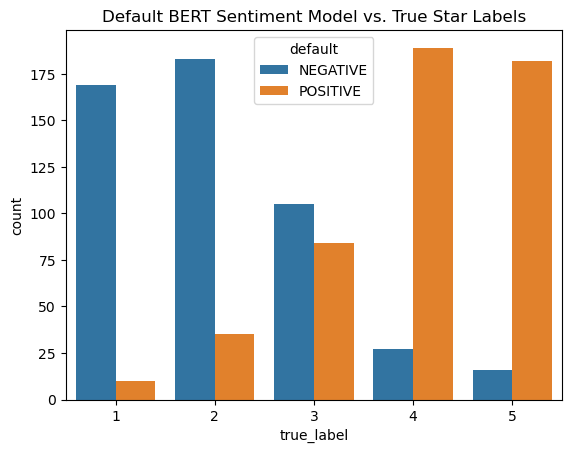

In [53]:
sns.countplot(x=sentiment_df['true_label'], hue=sentiment_df['default'])
plt.title("Default BERT Sentiment Model vs. True Star Labels")

Text(0.5, 1.0, 'Twitter-Trained Sentiment Model vs. True Star Labels')

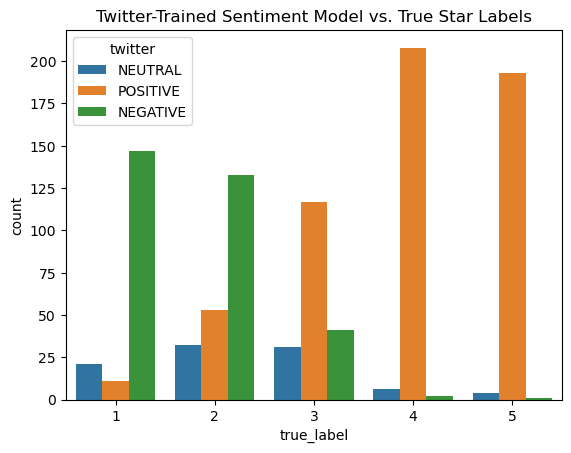

In [54]:
sns.countplot(x=sentiment_df['true_label'], hue=sentiment_df['twitter'])
plt.title("Twitter-Trained Sentiment Model vs. True Star Labels")

Text(0.5, 1.0, 'Yelp-Trained Sentiment Model vs. True Star Labels')

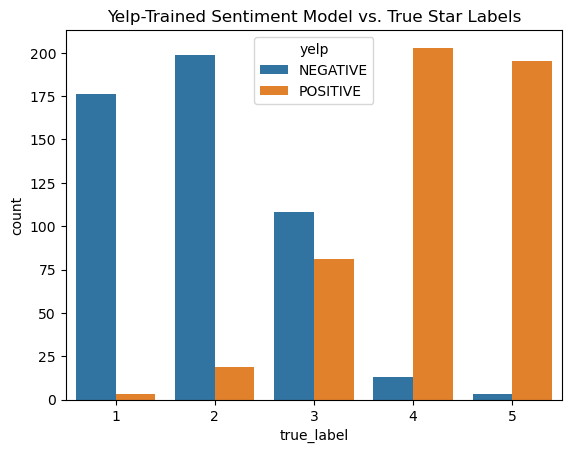

In [55]:
sns.countplot(x=sentiment_df['true_label'], hue=sentiment_df['yelp'])
plt.title("Yelp-Trained Sentiment Model vs. True Star Labels")

The one-star reviews classified as positive by Yelp-trained model seem to have confused the model because they include some positive words and feelings that were not directed at the quality of the experience users had at the restaurant. For example, in the third review shown below, the user is expressing a positive sentiment but they are happy about the restaurant closing and not about the restaurant's quality. Similarly in the second review shown below, the review starts out positive but then turns negative. The truncation likely also influenced why this particular review was misclassified.

In [56]:
print("One-star reviews that the yelp-trained model classified as positive:")
print()
for index in sentiment_df[(sentiment_df['true_label'] == 1) & (sentiment_df['yelp'] == 'POSITIVE')].index:
    print(review_texts[index])
    print()

One-star reviews that the yelp-trained model classified as positive:

i flew into philly for memorial day weekend and we left the airport and went straight here . yes i love food . as far as cheesesteaks go , i honestly have had better . i feel bad saying that , but i have , at philly connection in duluth , ga . it was nice to go for nostalgia sake though .

my husband and i were in the mood for crabs and heard about bonk ' s . we drove an hour to get there and were happy to see that the place was nice . we ordered the crab bisque and steamed clams and the jumbo crabs @ $ 8 each . the bisque was quite tasty , not great , but good enough . as soon as we saw the clams we ordered we thought uh oh . they were those cheap white clams that come from the very polluted china waters . we thought a place that supposedly is known for seafood would serve top necks or littl

it looks like karma has done it ' s job once more ! i heard they are no longer open ! good riddens !



Based on the reviews shown below that the Yelp-trained and default models disagreed on, it seems that the default BERT model may not be as atuned to the sarcasm of social media posts. For example, the review "rude bartenders are fun, limited tap list even better, and a bunch of drunk bros is the icing on the cake!" seems to be positive if one only looks at the words being used. However, a model more familiar with sarcasm would see that the underlying sentiment is negative.

In [57]:
print("One-star reviews that the yelp-trained model and default bert model disagreed on")
print()
for index in sentiment_df[(sentiment_df['yelp'] != sentiment_df['default']) & (sentiment_df['true_label'] == 1)].index:
    print(review_texts[index])
    print()

One-star reviews that the yelp-trained model and default bert model disagreed on

holy hell , i hate this place . even without the kiddies at 9 pm , the quality of food is subpar . they were out of several things i ordered . everything tasted canned or reheated . yeah , i ' m not expecting haute cuisine , but this is a step above vending machine . staff seems nice , but from my observations kept making apologizes to the two tables around me and myself . only go if you have young children , no choice or no taste buds .

rude bartenders are fun , limited tap list even better , and a bunch of drunk bros is the icing on the cake ! i rather not come back here and waste my time .

the service was ok . the food was good . te milkshake made me sick . they double charged my card and were extremely unprofessional and insincere about their mistake . i won ' t go back and wouldn ' t recommend it to anyone else ...

beer while you ' re here , i ' m going to need to see your id , right now ." woah d

In [58]:
print("Five-star reviews that the yelp-trained model and default bert model disagreed on")
print()
for index in sentiment_df[(sentiment_df['yelp'] != sentiment_df['default']) & (sentiment_df['true_label'] == 5)].index:
    print(review_texts[index])
    print()

Five-star reviews that the yelp-trained model and default bert model disagreed on

bruno ' s is a chestnut hill / lafayette hill institution but here ' s a little known fact . it ' s actually in neither of those jurisdictions but it ' s actually situated in the springfield panhandle . oh well , it doesn ' t matter . this classic malt shop and eatery is a great place to get nourished before or after a hike in the adjacent vale of the wissahickon .... or just go to for a downhome breakfast , lunch , dinner , or snack without the hike . indoors it looks just like a malt shop should ( even wi

on a fancy date to talula ' s garden in the hopes of sitting outside . however , it was raining , so we sat inside . this place is enormous , and each room had a totally different vibe . the bar was cool . but a little small . my only complaint about this meal was my cocktail , which was supposed to be an old fashioned , was a poorly made concoction of whiskey , bitters , and about an ounce of lemon 

### Comparing Sentiment Labels with our Model Labels

As another way of evaluating the models we trained previously, we also compared the sentiment analysis labels to our models' star labels. We were not able to include the ELMo models in this analysis due to the ELMo model training in a different environment, which prevented us from making predictions using the ELMo models. The Yelp-trained sentiment analysis model was used for this section since it aligns most with the true star labels.

Overall, it seems that for both the BERT and the LSTM models, the sentiment predictions align with the model's star predictions. The graphs follow a similar trend as how the sentiment vs. true labels graphs looked. This indicates that although our model accuracies were fairly low at only 60% on validation, our models are accurately predicting sentiment for the most part. 

In [59]:
# Getting the model predictions for LSTM
lstm_preds = np.argmax(lstm.predict(X_d_val[random_idx]), axis=1) + 1
sentiment_df['lstm_labels'] = lstm_preds

32/32 [==============================] - 1s 20ms/step


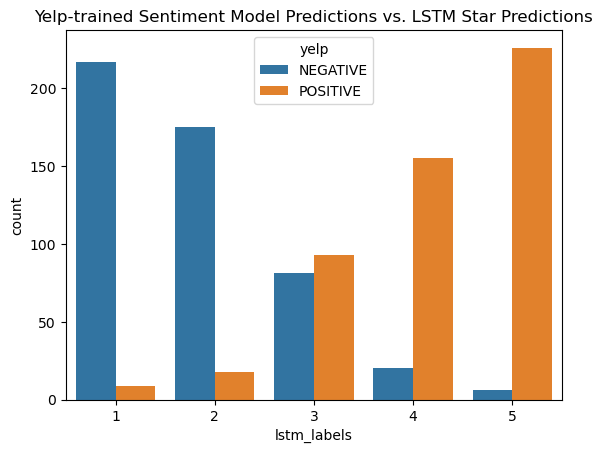

In [62]:
sns.countplot(x=sentiment_df['lstm_labels'], hue=sentiment_df['yelp'])
plt.title("Yelp-trained Sentiment Model Predictions vs. LSTM Star Predictions");

In [ ]:
# Repeat for BERT
def decode(arr):
    return [idx2word[i] for i in list(filter(lambda x: x != 0, arr))]
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
X_bert_val = tokenizer([decode(arr) for arr in X_d_val],
                         is_split_into_words=True,
                         return_tensors='tf',
                         max_length=256,
                         padding='max_length',
                         truncation=True)

In [117]:
bert_preds = np.argmax(bert.predict((X_bert_val['input_ids'].numpy()[random_idx], 
                                    X_bert_val['attention_mask'].numpy()[random_idx])).logits, axis=1) + 1
sentiment_df['bert_labels'] = bert_preds

32/32 [==============================] - 137s 4s/step


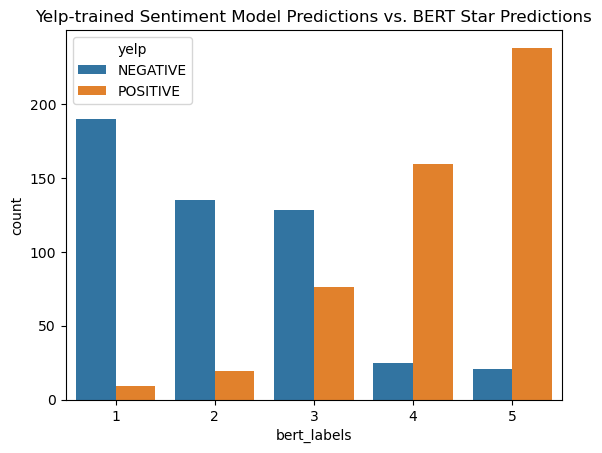

In [119]:
sns.countplot(x=sentiment_df['bert_labels'], hue=sentiment_df['yelp'])
plt.title("Yelp-trained Sentiment Model Predictions vs. BERT Star Predictions");

<a id="part11"></a>

# Latent Space Visualization (of LSTM)

[Return to contents](#contents)

This code extracts the outputs from the LSTM layer of our original LSTM Model (since it performed best) and uses them as features in a principal component analysis. This should reduce the dimensionality of the number of features being used to predict star-ratings from 32 to 2. Then, we plotted each review along the first two principal components and color-coded it based on the true number of stars it received to see if reviews with similar numbers of stars clustered along the first two principal components (i.e. we wanted to see if the first two principal components of outputs could be used to explain differences between star ratings, or if the predictions from this layer were arbitrary compared to the true labels). The visualization indicates that the first two principal components did explain variance in the number of stars a business received. And the cluster of 5-star reviews is adjacent to the cluster of 4-star reviews, which is adjacent to the cluster of 3-star reviews (and so on), which would intuitively be expected.

In [78]:
# Perform PCA on a layer of the specified model, to project the effects of all the layer's nodes onto the first 2 principal compoents
def get_hidden_output_PCA(model, X_test, y_test, layer_index, out_dimension):
    latent_space_extractor = Model(model.inputs, model.layers[layer_index].output)
    hidden_feature=np.array(latent_space_extractor([X_test]))

    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print(f'Variance explained by PCA: {np.sum(pca.explained_variance_ratio_):.2%}')
    return pca_result

In [101]:
from sklearn.decomposition import PCA
# Plot the results of PCA with reviews color-coded by their true star-rating
# To see if star-ratings and the bases for prediction out of the given model are clustered
def visualize_stars(pca_result, y_test):
    color = ['r', 'orange', 'y', 'g', 'b']
    category = y_test.flatten()
    for cat in np.arange(0, 5):
        indices = np.where(category==cat)[0]
        plt.scatter(pca_result[indices,0], pca_result[indices, 1], label=cat+1,s=2,color=color[cat],alpha=0.3)
    legend = plt.legend(markerscale=3)
    legend.get_frame().set_facecolor('w') 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Visualization of LSTM Features on Reduced Dimension by PCA")


Variance explained by PCA: 93.58%


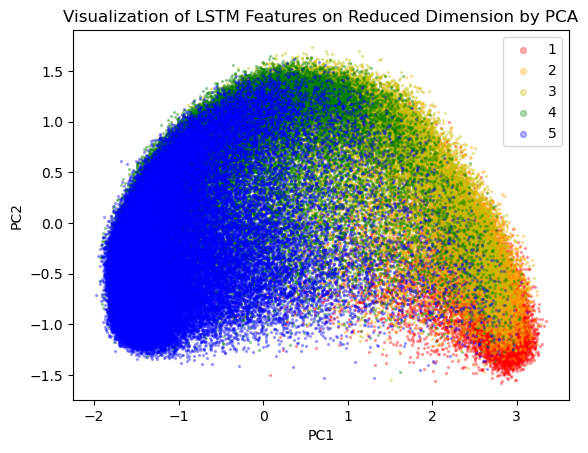

In [102]:
pca_result = get_hidden_output_PCA(lstm,
                                   X_test,
                                   y_test,
                                   2,
                                   32)
visualize_stars(pca_result, y_test)

<a id="part12"></a>

# Conclusion

[Return to contents](#contents)

## Comparing Models

Our models achieved varying levels of performance. The feed-forward neural network, as expected, performed poorly and almost always predicted a single class. The single-layer LSTM performed best, with accuracy of about 60%, but adding a second LSTM layer resulted in overfitting. Surprisingly, the more advanced LSTM with ELMo embeddings and DistilBERT didn't perform as well as the LSTM. DistilBERT favored predictions of class 2 and 5 in a somewhat confusing pattern. This goes to show that the most advanced model doesn't always perform the best.

The most likely reason for the relatively poor performance of the state-of-the-art techniques was a lack of training time and power. With sufficient time, we would hope to be able to train our models for long enough to reach good accuracy. Despite this difficulty, our models agreed largely with the pre-trained sentiment analysis models and seemed to distinguish between positive and negative reviews. On a related note, this task is quite difficult to begin with, even for humans, because Yelp users often leave ratings that seem to disagree with the content of their reviews.

## Improvements

To improve the LSTM model, we would try different architectures. When we attempted to add a second LSTM layer to the original LSTM model, it overfit to the training data (which was evident through validation scores), even with regularization. To control overfitting, we could try data augmentation (like generating synthetic data based on the text we have, using synonym replacement, or randomly masking words) or just using a larger dataset to begin with. 

To improve the BERT model (both in accuracy and efficiency), we could set a maximum length for its vocabulary. This would mean masking uncommon or misspelled words. It helps efficiency by having BERT learn fewer words, but also allows the model to learn language more accurately/perform better given future reviews by focusing on its most common traits. Additionally, we could try using a BERT model pre-trained on a corpus similar to Yelp reviews, such as Twitter tweets.

The improvements which would improve the BERT model would likely be instrumental in improving the ELMo model as well — in particular, given that there were so many parameters, it would have both decreased training time and likely increased accuracy if we had masked some tokens as being “<UNK>” instead of simply leaving every single word in the vocabulary. Additionally, if we had a lot of computational power at our disposal, it might be nice to even try fine-tuning the last few layers of the ELMo using the Yelp dataset, given that the ELMo was trained on Wikibooks, which is quite different from the casual reviews that we are using as input. 

We could also try a higher-dimensional principal component analysis. The motivation is that, with five classes of ratings to predict from nuanced elements of language, we would expect it to be difficult to explain variance in the ratings based on two principal components. It would not likely be advisable to analyze more than 3 principal components because this becomes difficult to visualize/interpret. But it's worth noting that the PCA in higher dimensions may not be necessary at all since the projection onto 2 principal components already explains a high percentage of variance (93%) in the data.

## Future Applications

Due to constraints on memory and hardware, this project chose to focus on predicting star-ratings and sentiments of Yelp text reviews for restaurants in Philadelphia. In future iterations this task could be extended to other cities (or hopefully to the entire Yelp dataset). It would also be interesting to apply the model to more active tasks, such as text-generation or recommendation of specific businesses. Using a generative pre-trained transformer (GPT) we imagine a model that could work opposite to the way our current models work: Generating reviews for restaurants given a star-label (i.e. a model that creates a 1-star review on command). Another model could factor in user-data (sentiments of their past reviews, or trends among the businesses they tend to rate highly--such as location of the business, number of stars the business has, etc.) to recommend specific businesses to specific users. We could also train a predictive model that goes beyond predicting sentiment or number of stars and predicts restaurant ratings based on objective qualities specific to restaurants. Examples of such qualities would be whether or not the restaurant has tablecloths, its average prices, and its real estate quality.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=64a56d10-f797-4f34-a142-e1a28ca8de96' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>